In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import layers

#NLP for text pre-processing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
# for spliting data set and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Handling imbalance data
from imblearn.over_sampling import SMOTE
# Plot the Figures Inline
%matplotlib inline

In [ ]:
#Loading the data
import_df = pd.read_csv('/content/drive/MyDrive/flipkart_com-ecommerce_sample.csv')

In [ ]:
#Preprocessing the category column for product categorization

import_df['category'] = import_df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:].strip() if isinstance(x, str) else x)


In [ ]:
#Saving the processed dataframe
import_df.to_csv('/content/drive/MyDrive/modified_ecom.csv', index=False)


In [ ]:
#Reading the processed dataframe

df=pd.read_csv("/content/drive/MyDrive/modified_ecom.csv")

In [ ]:
#Checking the unique category

df["category"].value_counts()

category
Clothing                                                 6198
Jewellery                                                3531
Footwear                                                 1227
Mobiles & Accessories                                    1099
Automotive                                               1012
                                                         ... 
Mast & Harbour Gold Synthetic  Clutch"]                     1
Asics Gel-Cumulus 17 Running Shoes"]                        1
Glacier Running Shoes"]                                     1
Starsy Solid Women's Round Neck Green T-Shirt"]             1
Areon Luxurious Fragrance Long Lasting Car,Home,..."]       1
Name: count, Length: 266, dtype: int64

In [ ]:
print(f"Total Number of top level categories {df['category'].nunique()}")

Total Number of top level categories 266


In [ ]:
#Taking only the top 15 category
df["category"].value_counts()[:15]

category
Clothing                      6198
Jewellery                     3531
Footwear                      1227
Mobiles & Accessories         1099
Automotive                    1012
Home Decor & Festive Needs     929
Beauty and Personal Care       710
Home Furnishing                700
Kitchen & Dining               647
Computers                      578
Watches                        530
Baby Care                      483
Tools & Hardware               391
Toys & School Supplies         330
Pens & Stationery              313
Name: count, dtype: int64

In [ ]:
#  Get the top 15 categories
top_15_categories = df['category'].value_counts().index[:15]

# Filter the original DataFrame
filtered_df = df[df['category'].isin(top_15_categories)]


In [ ]:
filtered_df['category'].value_counts()

category
Clothing                      6198
Jewellery                     3531
Footwear                      1227
Mobiles & Accessories         1099
Automotive                    1012
Home Decor & Festive Needs     929
Beauty and Personal Care       710
Home Furnishing                700
Kitchen & Dining               647
Computers                      578
Watches                        530
Baby Care                      483
Tools & Hardware               391
Toys & School Supplies         330
Pens & Stationery              313
Name: count, dtype: int64

In [ ]:
#  Save the new DataFrame as a CSV file
filtered_df.to_csv('top_15_categories.csv', index=False)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/top_15_categories.csv")

In [ ]:
df.shape

(18678, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18678 entries, 0 to 18677
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  18678 non-null  object 
 1   crawl_timestamp          18678 non-null  object 
 2   product_url              18678 non-null  object 
 3   product_name             18678 non-null  object 
 4   product_category_tree    18678 non-null  object 
 5   pid                      18678 non-null  object 
 6   retail_price             18617 non-null  float64
 7   discounted_price         18617 non-null  float64
 8   image                    18675 non-null  object 
 9   is_FK_Advantage_product  18678 non-null  bool   
 10  description              18676 non-null  object 
 11  product_rating           18678 non-null  object 
 12  overall_rating           18678 non-null  object 
 13  brand                    13006 non-null  object 
 14  product_specifications

**The e-commerce data set has 16 attributes; out of these columns, I only extracted the following elements for further analysis: description and category**

<Axes: title={'center': 'Product Category Distribution'}, xlabel='category'>

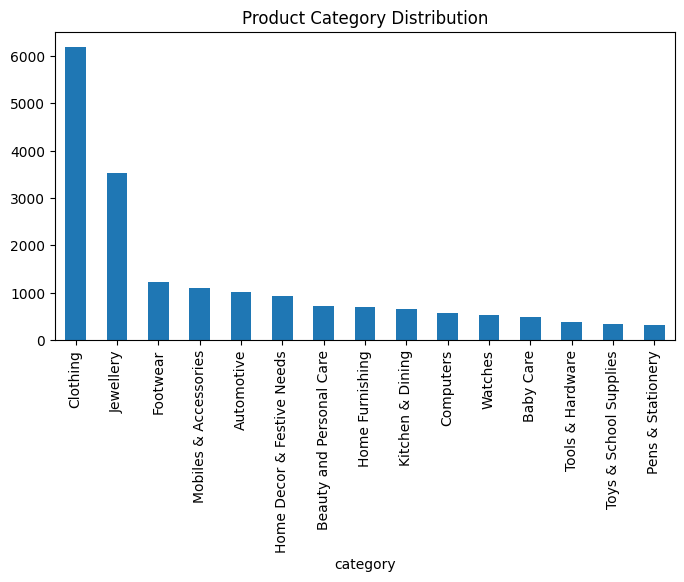

In [ ]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
df['category'].value_counts().plot(ax=ax,kind='bar', title='Product Category Distribution')

Most products belong to Clothing or Jewelry, followed by Footwear and Mobiles & Accessories. There are very few products under Watches, Pens & Stationary.

In [ ]:
# Number of missing values in each column
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0:'missing'})

In [ ]:
# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(df)
# sorting the values in descending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5672,0.303673
retail_price,61,0.003266
discounted_price,61,0.003266
product_specifications,13,0.000696
image,3,0.000161
description,2,0.000107
uniq_id,0,0.000000
crawl_timestamp,0,0.000000
product_url,0,0.000000
product_name,0,0.000000


Description feature has two missing value. Let’s drop that missing value observation
from the data set.

In [ ]:
#Removing missing values in description
df=df[pd.notnull(df['description'])]

In [ ]:
#Adding New column with no of words in the description before text preprocessing
df['no_of_words'] = df.description.apply(lambda a :len(a.split()))
bins=[0,50,75, np.inf]
df['bins']=pd.cut(df.no_of_words,bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-200', '200-500','500-800' ,'>800'])

words_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'word_counts'})


Text(0.5, 1.0, 'Word distribution per bin')

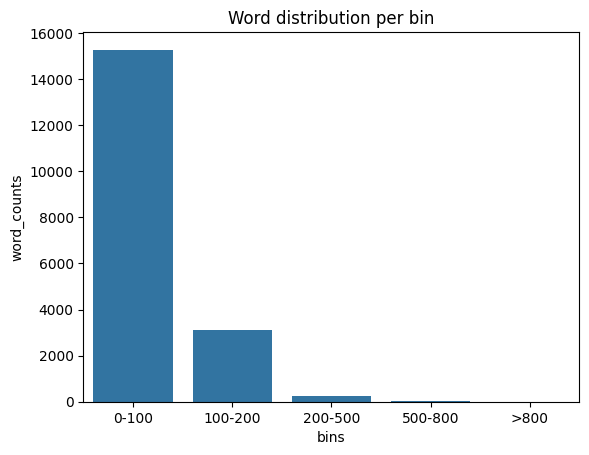

In [ ]:
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")

Most of the descriptions have fewer than 200 words. And more than 80% contains fewer than 100 words.

In [ ]:
#Preprocessing for text classification

df['description'][4]

'Key Features of dilli bazaaar Bellies, Corporate Casuals, Casuals Material: Fabric Occasion: Ethnic, Casual, Party, Formal Color: Pink Heel Height: 0,Specifications of dilli bazaaar Bellies, Corporate Casuals, Casuals General Occasion Ethnic, Casual, Party, Formal Ideal For Women Shoe Details Weight 200 g (per single Shoe) - Weight of the product may vary depending on size. Heel Height 0 inch Outer Material Fabric Color Pink'

In [ ]:
# Remove punctuation
df['description'] = df['description'].str.replace(r'[^\w\d\s]', ' ', regex=True)
# Replace whitespace between terms with a single space
df['description'] = df['description'].str.replace(r'\s+', ' ', regex=True)
# Remove leading and trailing whitespace
df['description'] = df['description'].str.replace(r'^\s+|\s+$', '', regex=True)
# Converting to lower case
df['description'] = df['description'].str.lower()
# Replace numbers like price values with 'numbr'
df['description'] = df['description'].str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)

df['description'][4]

'key features of dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications of dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal for women shoe details weight numbr g per single shoe weight of the product may vary depending on size heel height numbr inch outer material fabric color pink'

In [ ]:
#Removing General stop words
import re
import nltk
nltk.download('stopwords')

# Removing Stopwords
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(re.escape(word) for word in stop))
df['description'] = df['description'].str.replace(pattern, '', regex=True)
df['description'] = df['description'].str.replace(r'\s+', ' ', regex=True)

# Removing single characters
df['description'] = df['description'].apply(lambda a: " ".join(a for a in a.split() if len(a) > 1))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['description'][4]

'key features dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal women shoe details weight numbr per single shoe weight product may vary depending size heel height numbr inch outer material fabric color pink'

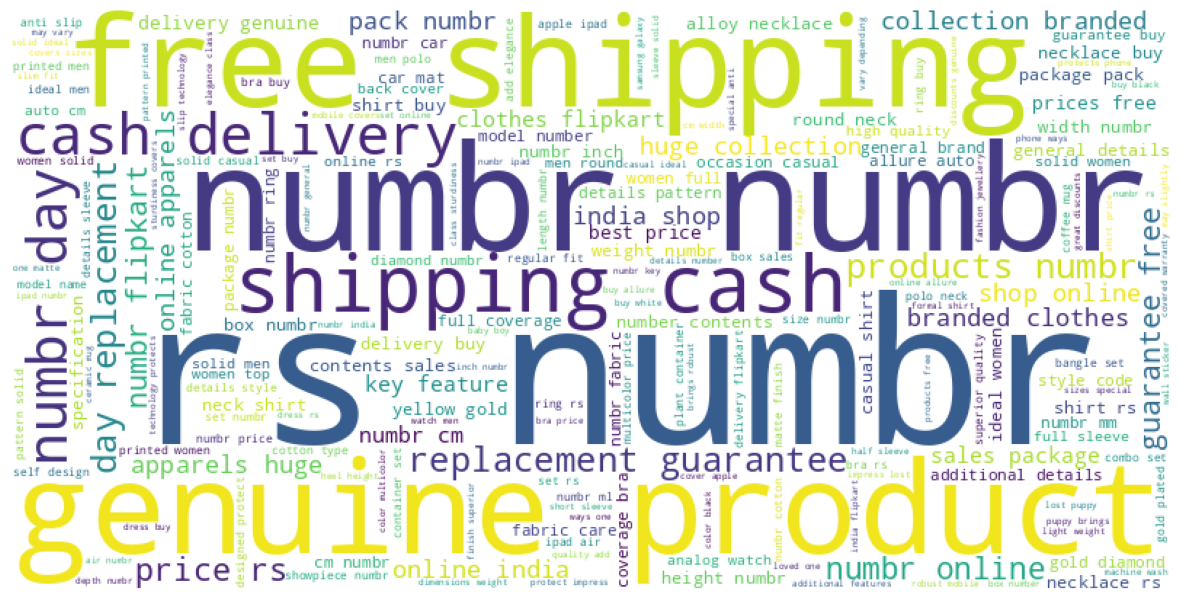

In [ ]:
#word cloud on descriptions to get to know the words that are appearing the greatest number of times.
wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(df['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

There are a lot of domain-related words occurring in the corpus, which add no value
to the task. For example, the word rs is an Indian currency present in most documents
but not useful.

In [ ]:
# Removing domain-related stop words from the description
specific_stop_words = ["numbr", "rs", "flipkart", "buy", "com", "free", "day",
                       "cash", "replacement", "guarantee", "genuine", "key",
                       "feature", "delivery", "products", "product", "shipping",
                       "online", "india", "shop"]

df['description'] = df['description'].apply(lambda a: " ".join(a for a in a.split() if a not in specific_stop_words))


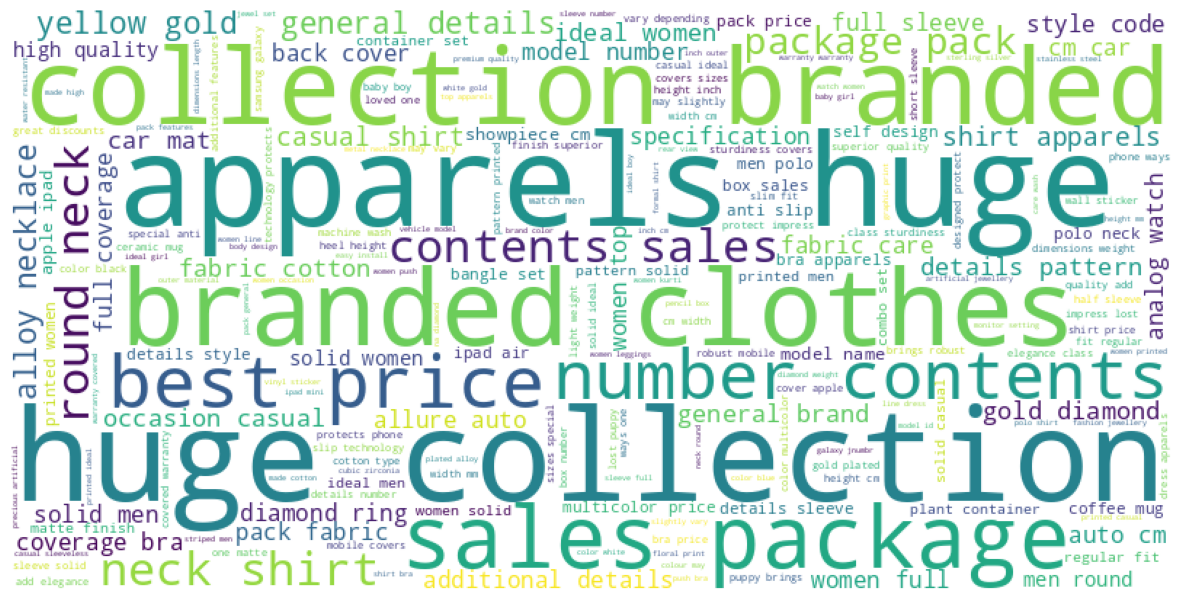

In [ ]:
#Wordcount after removal of domain specific word

wordcloud = WordCloud(background_color="white", width = 800, height = 400).generate(' '.join(df['description']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Feature Engineering

In [ ]:
max_length= 200
prod_tok = Tokenizer()
prod_tok.fit_on_texts(df['description'])
clean_description = prod_tok.texts_to_sequences(df['description'])
#padding
X = pad_sequences( clean_description, maxlen= max_length)



In [ ]:
# Label encoder for Target variable
num_class = len(np.unique(df.category.values))
y = df['category'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
# Create a mapping of labels to encoded values
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))

# Print the mapping
print("Label to Number Mapping:")
for label, number in label_mapping.items():
    print(f"{label} -> {number}")

# Print the encoded values for the target variable
print("\nEncoded values for the 'category' column:")
print(y)

Label to Number Mapping:
Automotive -> 0
Baby Care -> 1
Beauty and Personal Care -> 2
Clothing -> 3
Computers -> 4
Footwear -> 5
Home Decor & Festive Needs -> 6
Home Furnishing -> 7
Jewellery -> 8
Kitchen & Dining -> 9
Mobiles & Accessories -> 10
Pens & Stationery -> 11
Tools & Hardware -> 12
Toys & School Supplies -> 13
Watches -> 14

Encoded values for the 'category' column:
[3 5 3 ... 1 1 1]


In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1) #train 80, test 20
print(X_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(y_test.shape)

(14940, 200)
(3736, 200)
(14940,)
(3736,)


In [ ]:
#Customized Deep Neural Network

In [ ]:
vocab_size = len(prod_tok.word_index) + 1
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(X_train, Y_train)

# Print the distribution of the resampled dataset
print("Original dataset shape:", pd.Series(Y_train).value_counts())
print("Resampled dataset shape:", pd.Series(y_train).value_counts())

Original dataset shape: 3     4970
8     2831
5      973
10     882
0      822
6      742
7      563
2      557
9      502
4      455
14     426
1      388
12     312
13     268
11     249
Name: count, dtype: int64
Resampled dataset shape: 3     4970
8     4970
5     4970
2     4970
1     4970
4     4970
14    4970
6     4970
0     4970
10    4970
7     4970
13    4970
9     4970
12    4970
11    4970
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
#from datasets import load_dataset

In [ ]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
pip install transformers tensorflow pandas scikit-learn imbalanced-learn


In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
!pip install dill
!pip install joblib
import dill
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/top_15_categories.csv', delimiter=',')  # Adjust the delimiter if needed
df=df[pd.notnull(df['description'])]
# Preprocess the data
df['description'] = df['description'].astype(str)
df['category'] = df['category'].astype(str)

# Encode the labels
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

# Split the data into features and labels
X = df['description'].values
y = df['category'].values

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_data(descriptions, tokenizer):
    return tokenizer(
        descriptions.tolist(),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='tf'
    )

# Tokenize the descriptions
encodings = tokenize_data(X, tokenizer)
input_ids = encodings['input_ids'].numpy()
attention_masks = encodings['attention_mask'].numpy()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import TFBertModel
import numpy as np
import tensorflow as tf
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Function to create embeddings in smaller batches
def create_embeddings(model, input_ids, attention_masks, batch_size=4):
    embeddings = []
    num_batches = len(input_ids) // batch_size + int(len(input_ids) % batch_size != 0)
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        batch_input_ids = input_ids[start:end]
        batch_attention_masks = attention_masks[start:end]
        batch_embeddings = model(batch_input_ids, attention_mask=batch_attention_masks)[0][:, 0, :].numpy()
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings, axis=0)

# Create embeddings in smaller chunks
embeddings = create_embeddings(bert_model, input_ids, attention_masks, batch_size=4)

# Apply SMOTE to balance the data
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(embeddings, y)
# Save the embeddings, labels, label encoder, and function
np.save('/content/drive/MyDrive/embeddings.npy', X_resampled)
np.save('/content/drive/MyDrive/labels.npy', y_resampled)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
import joblib
joblib.dump(label_encoder, "/content/drive/MyDrive/label_encoder_3.pkl")

# Save the tokenizer and BERT model
tokenizer.save_pretrained('/content/drive/MyDrive/bert_tokenizer_3')
bert_model.save_pretrained('/content/drive/MyDrive/bert_model_3')

# Save the create_embeddings function
import dill
with open('/content/drive/MyDrive/create_embeddings.pkl', 'wb') as f:
    dill.dump(create_embeddings, f)


In [ ]:
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_embeddings, 'attention_mask': np.ones_like(train_embeddings)},
    train_labels
)).shuffle(1000).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_embeddings, 'attention_mask': np.ones_like(val_embeddings)},
    val_labels
)).batch(8)


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define custom layers
input_ids = Input(shape=(768,), dtype=tf.float32, name='input_ids')
dropout_layer = Dropout(0.3)(input_ids)
dense_layer = Dense(128, activation='relu')(dropout_layer)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=input_ids, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Stop training if validation loss doesn't improve for 5 epochs

history=model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


9296/9296 [==============================] - 29s 3ms/step - loss: 1.0035 - accuracy: 0.7238 - val_loss: 0.4071 - val_accuracy: 0.8970
Epoch 2/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.3881 - accuracy: 0.8903 - val_loss: 0.2653 - val_accuracy: 0.9221
Epoch 3/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.2973 - accuracy: 0.9108 - val_loss: 0.2119 - val_accuracy: 0.9363
Epoch 4/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.2580 - accuracy: 0.9202 - val_loss: 0.1839 - val_accuracy: 0.9413
Epoch 5/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.2338 - accuracy: 0.9267 - val_loss: 0.1572 - val_accuracy: 0.9483
Epoch 6/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.2182 - accuracy: 0.9298 - val_loss: 0.1447 - val_accuracy: 0.9513
Epoch 7/50
9296/9296 [==============================] - 26s 3ms/step - loss: 0.2066 - accuracy: 0.9331 - val_loss: 0.1358 - val_accuracy: 0.9

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/fine_tuned_model_tf_custom_3')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/fine_tuned_model_tf_custom_3')


('/content/drive/MyDrive/fine_tuned_model_tf_custom_3/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_model_tf_custom_3/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_model_tf_custom_3/vocab.txt',
 '/content/drive/MyDrive/fine_tuned_model_tf_custom_3/added_tokens.json')

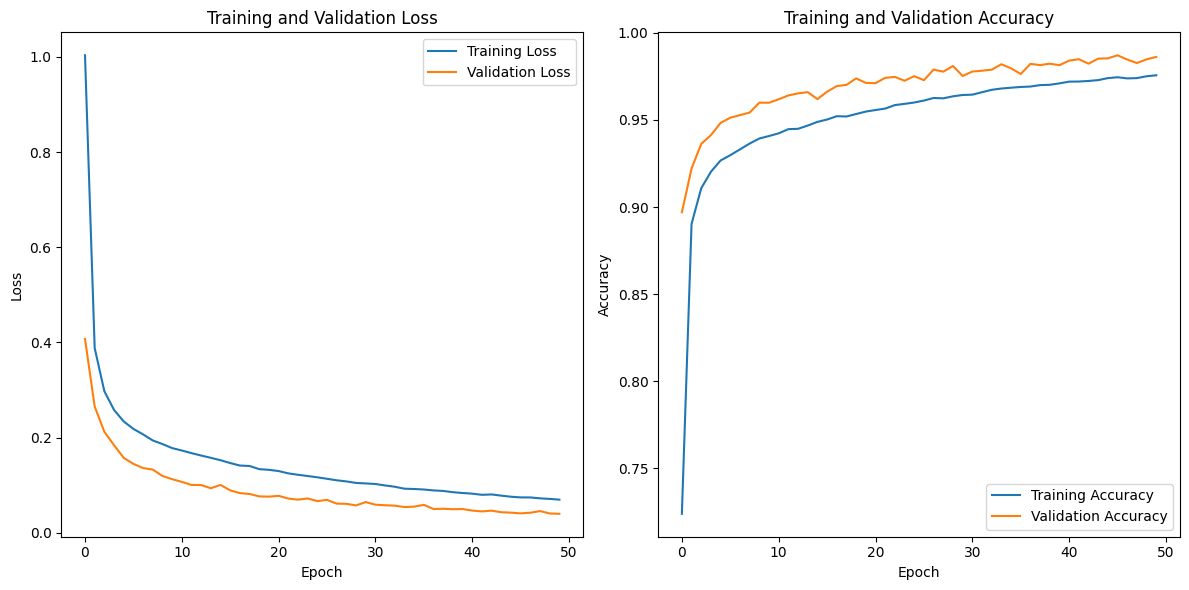

In [ ]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import joblib
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import load_model
import dill

# Load the embeddings, labels, label encoder, and function
X_resampled = np.load('/content/drive/MyDrive/embeddings.npy')
y_resampled = np.load('/content/drive/MyDrive/labels.npy')
label_encoder = joblib.load("/content/drive/MyDrive/label_encoder_3.pkl")

# Load the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_tokenizer_3')
bert_model = TFBertModel.from_pretrained('/content/drive/MyDrive/bert_model_3')

# Load the create_embeddings function
with open('/content/drive/MyDrive/create_embeddings.pkl', 'rb') as f:
    create_embeddings = dill.load(f)

# Load the trained model
model = load_model('/content/drive/MyDrive/fine_tuned_model_tf_custom_3')

# Get the class names
class_names = list(label_encoder.classes_)
class_dict = {index: name for index, name in enumerate(class_names)}

# Function to predict class of text
def predict_class(text):
    # Tokenize input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='tf')

    # Create BERT embeddings
    input_ids = inputs['input_ids'].numpy()
    attention_masks = inputs['attention_mask'].numpy()
    embeddings = create_embeddings(bert_model, input_ids, attention_masks, batch_size=1)

    # Make prediction
    predictions = model.predict(embeddings)

    # Get predicted class
    predicted_class = predictions.argmax(axis=1)[0]

    return predicted_class

# Take input from user
user_text = input("Enter text: ")

# Predict class
predicted_class_index = predict_class(user_text)
predicted_class_name = class_dict[predicted_class_index]

print("Predicted class index:", predicted_class_index)
print("Predicted class name:", predicted_class_name)


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/MyDrive/bert_model_3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Enter text: laptops
1/1 [==============================] - 0s 41ms/step
Predicted class index: 4
Predicted class name: Computers


Long Short-Term Memory: Recurrent Neural Networks

In [ ]:
model_inp = Input(shape=(max_length, ))
#define embedding layer
object_layer = Embedding(vocab_size,100,input_length=max_length)(model_inp)
#add LSTM layer
a = LSTM(60)(object_layer)
#add dense layer
a = Dense(30)(a) #default activation function is linear, we can make use of relu.
#final
model_pred = Dense(num_class, activation='softmax')(a)
model_2 = Model(inputs=[model_inp], outputs=model_pred)


In [ ]:
#compile
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          1875700   
                                                                 
 lstm (LSTM)                 (None, 60)                38640     
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dense_3 (Dense)             (None, 15)                465       
                                                                 
Total params: 1916635 (7.31 MB)
Trainable params: 1916635 (7.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
filepath="/content/drive/MyDrive/model_cat_LSTM.hdf5"
#model checkpoint
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [ ]:
#fitting
history = model_2.fit([x_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25,shuffle=True, epochs=5, callbacks=[x])


Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 1.2177 - acc: 0.6297
Epoch 1: val_acc improved from -inf to 0.79518, saving model to /content/drive/MyDrive/model_cat_LSTM.hdf5
176/176 [==============================] - 19s 95ms/step - loss: 1.2177 - acc: 0.6297 - val_loss: 0.8092 - val_acc: 0.7952
Epoch 2/5
  1/176 [..............................] - ETA: 19s - loss: 0.6264 - acc: 0.8438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - ETA: 0s - loss: 0.3708 - acc: 0.9042
Epoch 2: val_acc improved from 0.79518 to 0.93521, saving model to /content/drive/MyDrive/model_cat_LSTM.hdf5
176/176 [==============================] - 13s 71ms/step - loss: 0.3708 - acc: 0.9042 - val_loss: 0.2477 - val_acc: 0.9352
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.1664 - acc: 0.9552
Epoch 3: val_acc improved from 0.93521 to 0.94003, saving model to /content/drive/MyDrive/model_cat_LSTM.hdf5
176/176 [==============================] - 9s 48ms/step - loss: 0.1664 - acc: 0.9552 - val_loss: 0.2053 - val_acc: 0.9400
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 0.1011 - acc: 0.9733
Epoch 4: val_acc improved from 0.94003 to 0.95556, saving model to /content/drive/MyDrive/model_cat_LSTM.hdf5
176/176 [==============================] - 7s 37ms/step - loss: 0.1011 - acc: 0.9733 - val_loss: 0.1618 - val_acc: 0.9556
Epoch 5/5
176/176 [========================

In [ ]:
#model_2.load_weights('output_LSTM.hdf5')
#predicting on validation data
y_pred = model_2.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
#score
accuracy_score(y_test, y_pred)

117/117 [==============================] - 1s 5ms/step


0.9593147751605996

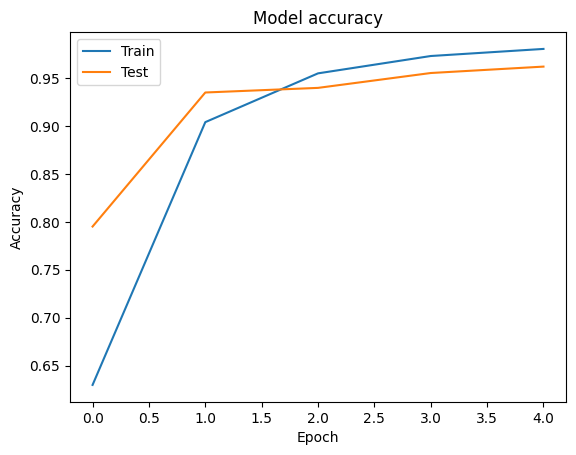

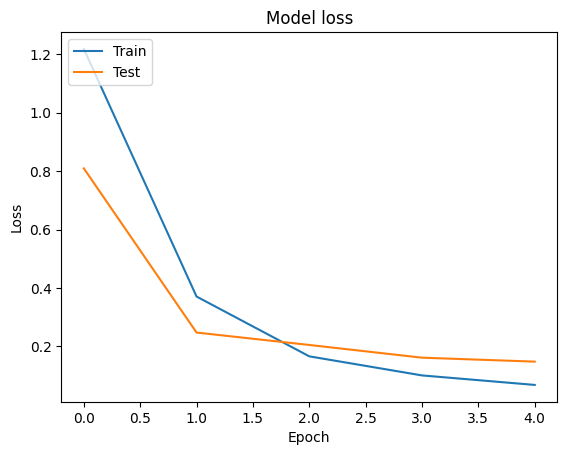

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Convolutional Neural Networks

In [ ]:
model_inp = Input(shape=(max_length, ))
# define the layer
object_layer = Embedding(vocab_size,100,input_length=max_length)(model_inp)
#conv layer
a = Conv1D(60, 10)(object_layer) #default activation function is linear, we can make use of relu.
#add pooling layer
a = MaxPooling1D(pool_size=2)(a)
#add LSTM
a = LSTM(60)(a)
a = Dense(30)(a)
#final layer
model_pred = Dense(num_class, activation='softmax')(a)
model_3 = Model(inputs=[model_inp], outputs=model_pred)


In [ ]:
#compile
model_3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          1875700   
                                                                 
 conv1d (Conv1D)             (None, 191, 60)           60060     
                                                                 
 max_pooling1d (MaxPooling1  (None, 95, 60)            0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                           

In [ ]:
filepath="/content/drive/MyDrive/model_cat_CNN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_3.fit([x_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25,shuffle=True, epochs=5, callbacks=[x])


Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 1.1106 - acc: 0.6814
Epoch 1: val_acc improved from -inf to 0.81365, saving model to /content/drive/MyDrive/model_cat_CNN.hdf5
176/176 [==============================] - 15s 67ms/step - loss: 1.1106 - acc: 0.6814 - val_loss: 0.6143 - val_acc: 0.8137
Epoch 2/5
  1/176 [..............................] - ETA: 1s - loss: 0.6065 - acc: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - ETA: 0s - loss: 0.3021 - acc: 0.9172
Epoch 2: val_acc improved from 0.81365 to 0.92369, saving model to /content/drive/MyDrive/model_cat_CNN.hdf5
176/176 [==============================] - 9s 52ms/step - loss: 0.3021 - acc: 0.9172 - val_loss: 0.2696 - val_acc: 0.9237
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.1351 - acc: 0.9625
Epoch 3: val_acc improved from 0.92369 to 0.94806, saving model to /content/drive/MyDrive/model_cat_CNN.hdf5
176/176 [==============================] - 6s 32ms/step - loss: 0.1351 - acc: 0.9625 - val_loss: 0.2067 - val_acc: 0.9481
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 0.0786 - acc: 0.9789
Epoch 4: val_acc improved from 0.94806 to 0.95957, saving model to /content/drive/MyDrive/model_cat_CNN.hdf5
176/176 [==============================] - 5s 26ms/step - loss: 0.0786 - acc: 0.9789 - val_loss: 0.1659 - val_acc: 0.9596
Epoch 5/5
175/176 [============================

In [ ]:
#model_3.load_weights('output_CNN.hdf5')
y_pred = model_3.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred)

117/117 [==============================] - 0s 4ms/step


0.9571734475374732

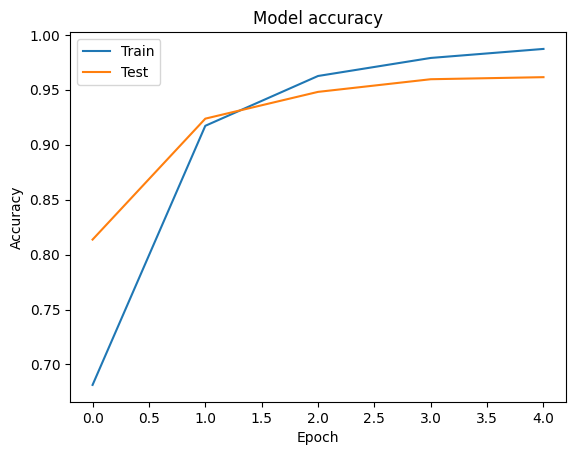

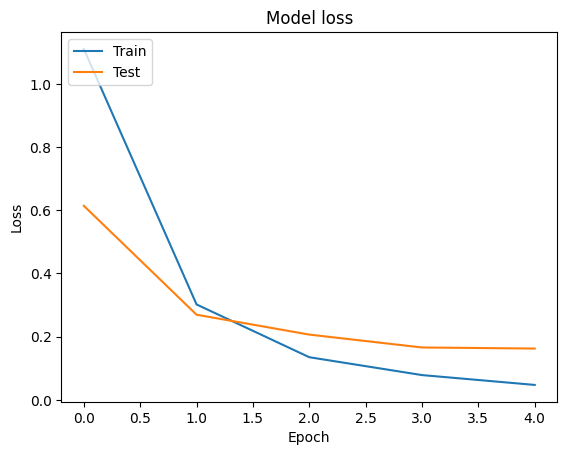

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


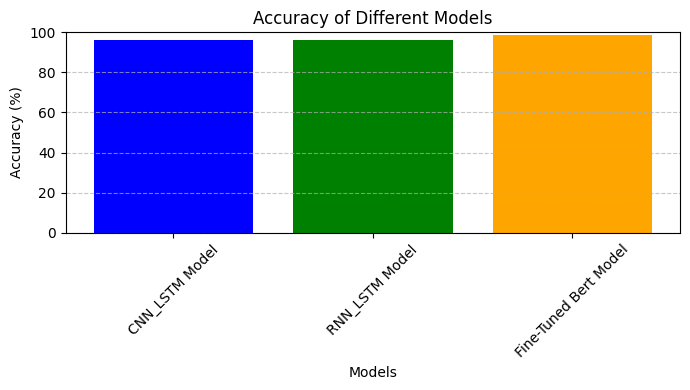

Accuracy of Different Models:
-------------------------------
CNN_LSTM Model: 96.14%
RNN_LSTM Model: 96.22%
Fine-Tuned Bert Model: 98.62%


In [1]:
import matplotlib.pyplot as plt

# Accuracy values
models = ['CNN_LSTM Model', 'RNN_LSTM Model','Fine-Tuned Bert Model']
accuracies = [96.14, 96.22,98.62]

# Bar chart
plt.figure(figsize=(7, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tabular format
print("Accuracy of Different Models:")
print("-------------------------------")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.2f}%")


Hyperparameter tuning
